# Smoothing

There are many options to use smoothing for probabilistic IVP solving.
Here is how.


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import ivpsolve, ivpsolvers, solution
from probdiffeq.doc_util import notebook
from probdiffeq.statespace import recipes
from probdiffeq.strategies import filters, smoothers

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_platform_name", "cpu")

In [3]:
def strategy_to_string(strat):
    name_strategy = strat.__class__.__name__
    name_impl = strat.implementation.__class__.__name__
    return f"{name_strategy}({name_impl}(...))"

In [4]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 10.0))


@jax.jit
def vf(*ys, t, p):
    return f(*ys, *p)

## Terminal-value simulation

If you are interested in the terminal value of the ODE solution, you can use filters and smoothers interchangeably.
But be aware that a smoother computes more intermediate values than a filter, so filters are more efficient here.

In [5]:
ekf0 = ivpsolvers.MLESolver(filters.Filter(recipes.ts0_iso()))
ekf0sol = ivpsolve.simulate_terminal_values(
    vf,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    solver=ekf0,
    parameters=f_args,
)
print(ekf0sol.t, ekf0sol.u)

10.0 [11.866939  2.633009]


## Traditional simulation

If you are used to calling traditional solve() methods, use one a conventional smoother (i.e. not the fixed-point smoother).

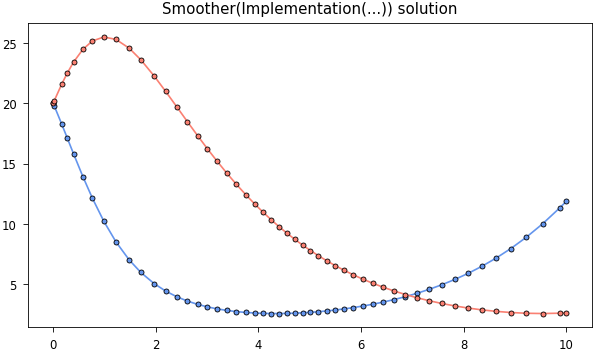

In [6]:
eks0 = ivpsolvers.MLESolver(smoothers.Smoother(recipes.ts0_iso()))
eks0sol = ivpsolve.solve_with_python_while_loop(
    vf,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    solver=eks0,
    parameters=f_args,
)

plt.subplots(figsize=(5, 3))
plt.title(f"{strategy_to_string(eks0.strategy)} solution")
plt.plot(eks0sol.t, eks0sol.u, ".-")
plt.show()

If you like, compute the solution on a dense grid after solving.

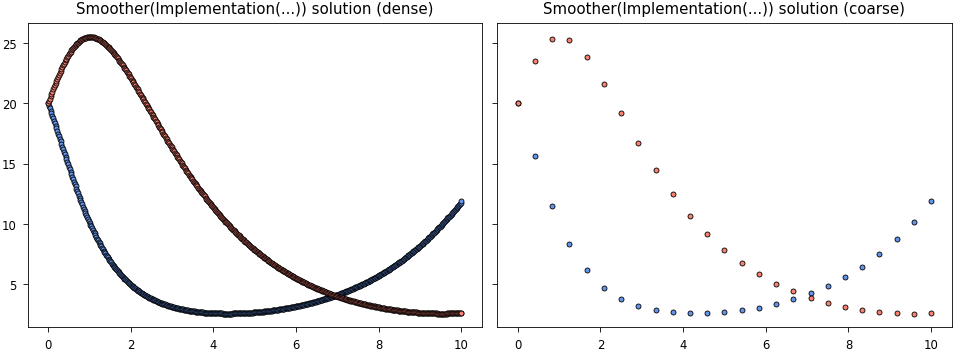

In [7]:
ts_dense = jnp.linspace(
    t0 + 1e-4, t1 - 1e-4, num=500, endpoint=True
)  # must be off-grid
dense, _ = solution.offgrid_marginals_searchsorted(
    ts=ts_dense, solution=eks0sol, solver=eks0
)

ts_coarse = jnp.linspace(
    t0 + 1e-4, t1 - 1e-4, num=25, endpoint=True
)  # must be off-grid
coarse, _ = solution.offgrid_marginals_searchsorted(
    ts=ts_coarse, solution=eks0sol, solver=eks0
)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 3))


ax1.set_title(f"{strategy_to_string(eks0.strategy)} solution (dense)")
ax1.plot(ts_dense, dense, ".")

ax2.set_title(f"{strategy_to_string(eks0.strategy)} solution (coarse)")
ax2.plot(ts_coarse, coarse, ".")
plt.show()

## Checkpoint simulation

If you know in advance that you like to have the solution at a pre-specified set of points only,
use the solve_and_save_at function together with a fixed-point smoother.


    !!! "Warning: EXPERIMENTAL feature!" !!!



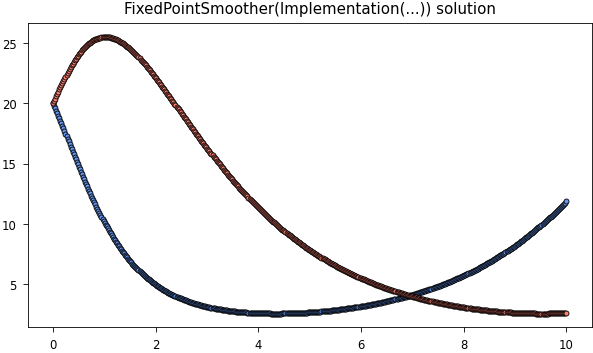

In [8]:
eks0_fixpt = ivpsolvers.MLESolver(smoothers.FixedPointSmoother(recipes.ts0_iso()))
fixptsol = ivpsolve.solve_and_save_at(
    vf,
    initial_values=(u0,),
    save_at=ts_dense,  # reuse from above
    solver=eks0_fixpt,
    parameters=f_args,
)

plt.subplots(figsize=(5, 3))
plt.title(f"{strategy_to_string(eks0_fixpt.strategy)} solution")
plt.plot(fixptsol.t, fixptsol.u, ".-")
plt.show()